In [86]:
import pathlib
import pandas as pd
import numpy as np
from itertools import combinations
# plotting libraries
from matplotlib import pyplot as plt
import seaborn as sns
import seaborn.objects as so
from seaborn import axes_style
# machine learning libraries
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report, accuracy_score
# stats
import statsmodels.api as sm
from statsmodels import stats as sms
import statsmodels.formula.api as smf
from scipy import stats

import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)


# Parameters

In [93]:
DATA_DIR = '../data/3secondsafodoronset_afcondition'
RNG_SEED = 1

# Model performance

## Utility functions

In [94]:
def logistic_regression_performance(data, rng=np.random.default_rng(0)):
    '''
    Fit a vanilla logistic regression and report f1 score per odor and overall accuracy score
    Fitted model is not saved or returned!
    
    Args:
        data: pd.DataFrame  # dataframe with columns 'odor', 'exp' and a number of 'feature' columns,
        'odor' column is the prediction target,
        columns prefixed with 'feature' will be used as predictors of the regression model,
        'exp' column is kept for record keeping purposes
        rng: numpy.random._generator.Generator  # random generator used in cross validation, fix it to reproduce the same results
    
    Return:
        f1score_df: pd.DataFrame  # dataframe recording cross validated f1 scores, each row is one cross validation sample
        accuracy_df: pd.DataFrame  # dataframe recording cross validated accuracy scores
    '''
    # split data to X and y
    X = data.filter(like='feature').to_numpy()
    y = data.odor.to_numpy()
    # data quality control
    unique_odor, counts = np.unique(y, return_counts=True)
    assert len(np.unique(counts)) == 1, "Imbalanced experimental design!"
    assert data.exp.nunique() == 1, "More than one experiment is found!"
    assert data.isna().sum().sum() == 0, "NaN values found in dataset!"
    # log information about the dataset
    logging.info(
        'There are %d trials where %d odors are presented %d times', 
        len(y),
        len(unique_odor),
        np.unique(counts)[0], 
    )
    logging.info(
        '%d features were extracted from population neural responses', 
        X.shape[1],
    )
    # configure model
    model = make_pipeline(StandardScaler(), LogisticRegression())  # classification pipeline combines a standardization step (substract by mean and divide by std) and a vanilla logistic regression model
    # estimate variance of model performance through 5x2 cross validation
    cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=5, random_state=np.random.RandomState(rng.bit_generator))
    f1score = []
    accuracy = []
    true_labels = []  # List to store true labels
    pred_labels = []  # List to store predicted labels
    for train_idx, test_idx in cv.split(X, y):
        # train model on the training set
        model = model.fit(X[train_idx], y[train_idx])
        true_labels.extend(y[test_idx])
        # obtain predicted labels
        pred_labels.extend(model.predict(X[test_idx]))
        # evaluate on test set
        f1score.append(
            f1_score(y[test_idx], model.predict(X[test_idx]), average=None)
        )
        accuracy.append(
            accuracy_score(y[test_idx], model.predict(X[test_idx]))
        )
    f1score = np.stack(f1score)
    accuracy = np.stack(accuracy)
    f1score_df = pd.DataFrame(
        data=f1score, 
        index=np.arange(f1score.shape[0]), 
        columns=model.classes_,
    )
    f1score_df = pd.melt(f1score_df, var_name='odor', value_name='f1_score')
    f1score_df['odor'] = pd.Categorical(f1score_df['odor'])
    f1score_df['exp'] = data.exp.unique()[0]
    accuracy_df = pd.Series(accuracy).to_frame('accuracy')
    accuracy_df['exp'] = data.exp.unique()[0]
    return f1score_df, accuracy_df, true_labels, pred_labels

In [77]:
#Training and testing with different datasets
def logistic_regression_performance_cross(data_train, data_test, rng=np.random.default_rng(0)):
    '''
    Fit a vanilla logistic regression and report f1 score per odor and overall accuracy score
    Fitted model is not saved or returned!
    
    Args:
        data: pd.DataFrame  # dataframe with columns 'odor', 'exp' and a number of 'feature' columns,
        'odor' column is the prediction target,
        columns prefixed with 'feature' will be used as predictors of the regression model,
        'exp' column is kept for record keeping purposes
        rng: numpy.random._generator.Generator  # random generator used in cross validation, fix it to reproduce the same results
    
    Return:
        f1score_df: pd.DataFrame  # dataframe recording cross validated f1 scores, each row is one cross validation sample
        accuracy_df: pd.DataFrame  # dataframe recording cross validated accuracy scores
    '''
    assert all(
        data_train.filter(like='feature').columns == data_test.filter(like='feature')
    ), 'columns of train and test do not align!'
    # split data to X and y
    X = data_train.filter(like='feature').to_numpy()
    y = data_train.odor.to_numpy()
    X_test = data_test.filter(like='feature').to_numpy()
    y_test = data_test.odor.to_numpy()
    # data quality control
    unique_odor, counts = np.unique(y, return_counts=True)
    assert len(np.unique(counts)) == 1, "Imbalanced experimental design!"
    assert (data_train.exp.nunique() == 1) and (data_test.exp.nunique() == 1), "More than one experiment is found!"
    assert (data_train.isna().sum().sum() == 0) and (data_test.isna().sum().sum() == 0), "NaN values found in dataset!"
    # log information about the dataset
    logging.info(
        'There are %d trials where %d odors are presented %d times', 
        len(y),
        len(unique_odor),
        np.unique(counts)[0], 
    )
    logging.info(
        '%d features were extracted from population neural responses', 
        X.shape[1],
    )
    # configure model
    model = make_pipeline(StandardScaler(), LogisticRegression())  # classification pipeline combines a standardization step (substract by mean and divide by std) and a vanilla logistic regression model
    # estimate variance of model performance through 5x2 cross validation
    cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=5, random_state=np.random.RandomState(rng.bit_generator))
    f1score = []
    accuracy = []
    for train_idx, test_idx in cv.split(X, y):
        # train model on the training set
        model = model.fit(X[train_idx], y[train_idx])
        # evaluate on test set
        f1score.append(
            f1_score(y_test, model.predict(X_test), average=None)
        )
        accuracy.append(
            accuracy_score(y_test, model.predict(X_test))
        )
    f1score = np.stack(f1score)
    accuracy = np.stack(accuracy)
    f1score_df = pd.DataFrame(
        data=f1score, 
        index=np.arange(f1score.shape[0]), 
        columns=model.classes_,
    )
    f1score_df = pd.melt(f1score_df, var_name='odor', value_name='f1_score')
    f1score_df['odor'] = pd.Categorical(f1score_df['odor'])
    f1score_df['exp'] = data.exp.unique()[0]
    accuracy_df = pd.Series(accuracy).to_frame('accuracy')
    accuracy_df['exp'] = data.exp.unique()[0]
    return f1score_df, accuracy_df

In [95]:
def contributionofneurons_allneuron(_data):
    _data = _data.query('odor != 1')
    
    X = _data.filter(like='feature').to_numpy()
    y = _data.odor.to_numpy()
    
    # Train the logistic regression model
    model = make_pipeline(StandardScaler(), LogisticRegression())
    model.fit(X, y)
    
    # Get the coefficients (weights) of the logistic regression model
    coefficients = model.named_steps['logisticregression'].coef_
    
    # Reshape the coefficients matrix to represent each neuron with its weights across all time points
    num_neurons = coefficients.shape[1] // 45
    weights_by_neuron = coefficients.reshape(coefficients.shape[0], num_neurons, -1)
    
    return weights_by_neuron

In [24]:
# Initialize an empty list to store the weights for each experiment
weights_by_exp = []

# Iterate through each experiment
for exp in data.exp.unique():
    _data = data[data['exp'] == exp]
    _data = _data.dropna(axis=1)
    
    # Compute the weights for all neurons in the current experiment
    weights_by_neuron = contributionofneurons_allneuron(_data)
    
    # Append the weights for the current experiment to the list
    weights_by_exp.append(weights_by_neuron)

# Concatenate the weights of all experiments along the second axis (axis=1)
weightall = np.concatenate(weights_by_exp, axis=1)

# Verify the shape of the concatenated matrix
print("Shape of concatenated weight matrix:", weightall.shape)

Shape of concatenated weight matrix: (4, 118, 45)


In [168]:
pip install scipy

Note: you may need to restart the kernel to use updated packages.


In [102]:
import scipy.io



# Save the matrix to a MATLAB file
scipy.io.savemat('weightall.mat', {'weightall': weightall})

In [103]:
def contributionofneurons(_data):  # output 'weight sorted, weight before sorted'
 _data = _data.query('odor != 1')
 
 X = _data.filter(like='feature').to_numpy()
 y = _data.odor.to_numpy()
 model = make_pipeline(StandardScaler(), LogisticRegression())  # classification pipeline combines a standardization step (substract by mean and divide by std) and a vanilla logistic regression model
 model = model.fit(X, y)
    #plt.figure(figsize=[10,5])
    #sns.heatmap(model.named_steps['logisticregression'].coef_, cmap='bwr')

 datata=model.named_steps['logisticregression'].coef_

 chunk_size = 45

    # Calculate the averages for every 45 columns within the same row
 averages = [row[i:i+chunk_size].mean() for row in datata for i in range(0, len(row), chunk_size)]
 averages=abs(np.array(averages).reshape(datata.shape[0],int(datata.shape[1]/chunk_size)) )
 odorsorted=[]
 indices=[]
 for idx in range(len(averages)):
    _odorsorted=averages[idx, averages[idx, :].argsort()]
    _indices=averages[idx, :].argsort()
    odorsorted.append(_odorsorted)
    indices.append(_indices)
      #sns.heatmap(averages_odor2sorted, cmap='viridis')
 odor_sorted_ind=odorsorted+indices
 
 return odor_sorted_ind,averages

## Load data

In [100]:
# random seed used for all downstream analysis
rng = np.random.default_rng(RNG_SEED)
# load all data
data = []
for filename in pathlib.Path(DATA_DIR).glob('*.csv'):
    _data = pd.read_csv(filename, header=None)  # load csv file
    _data.columns = [f'feature_{i}' for i in range(len(_data.columns)-1)] + ['odor']  # rename columns
    _data['exp'] = filename.stem  # log experiment name as file name
    data.append(_data)
    logging.info(f'loaded dataset: {filename}')
data = pd.concat(data)
data


INFO:root:loaded dataset: ../data/3secondsafodoronset_afcondition/102723_A94Nt_tracesfeature_odorafcondition_3SECAFODORONSET.csv
INFO:root:loaded dataset: ../data/3secondsafodoronset_afcondition/100923_A89Nt_tracesfeature_odorafcondition_25cells_3secafodoronset.csv
INFO:root:loaded dataset: ../data/3secondsafodoronset_afcondition/100923_A88R1_tracesfeature_odorafcondition_3SECAFODORONSET.csv
INFO:root:loaded dataset: ../data/3secondsafodoronset_afcondition/061523_A75L1_tracesfeature_odorafcondition_3SECAFODORONSET.csv
INFO:root:loaded dataset: ../data/3secondsafodoronset_afcondition/040723_A66Nt_tracesfeature_odorafcondition_3SECAFODORONSET.csv
INFO:root:loaded dataset: ../data/3secondsafodoronset_afcondition/102723_A94R1_tracesfeature_odorafcondition_3SECAFODORONSET.csv


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_1115,feature_1116,feature_1117,feature_1118,feature_1119,feature_1120,feature_1121,feature_1122,feature_1123,feature_1124
0,0.525134,0.301432,0.596431,0.607268,0.292493,0.245787,0.236642,0.562111,0.283652,0.174293,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-0.003826,-0.060868,0.107631,-0.165772,0.068217,-0.157367,-0.001749,0.220030,0.122312,-0.061573,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-0.071883,0.021279,-0.193773,0.056629,0.016155,0.237382,0.663861,0.475603,0.237677,0.083516,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-0.347779,-0.359863,-0.129521,-0.487824,-0.310994,-0.184741,-0.696609,-0.395657,0.038419,-0.383495,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.220681,-0.076895,-0.015677,-0.112712,0.620455,0.104854,0.422928,-0.231576,-0.223155,-0.407908,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,-0.245623,0.024553,0.160286,-0.194227,0.200600,-0.352615,0.215056,0.111486,-0.232175,-0.107613,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46,-0.219052,0.029838,0.179681,0.178782,0.149107,0.107448,0.241506,0.057360,0.228300,0.058210,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47,-0.466793,-0.148987,-0.165245,0.049243,-0.243599,-0.182566,-0.014918,0.009380,0.129307,-0.018002,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48,0.779187,0.196190,0.480367,0.583111,0.843681,0.602793,0.763505,0.620890,0.530046,0.362081,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [101]:
# train data by experiment
f1score_df = []
accuracy_df = []
# Initialize lists to store true and predicted labels for all experiments
all_true_labels = []
all_pred_labels = []
for exp, _data in data.groupby('exp'):
    logging.info(f'Training models for {exp}:')
    _data = _data.dropna(axis=1)  # drop feature columns containing nans
    _data = _data.query('odor != 1')  # remove odor 1
    
    _f1score_df, _accuracy_df,_true_labels,_pred_labels= logistic_regression_performance(_data, rng)
   
    f1score_df.append(_f1score_df)
    accuracy_df.append(_accuracy_df)
  
     # Append true labels and predicted labels to the lists for all experiments
    all_true_labels.extend(_true_labels)
    all_pred_labels.extend(_pred_labels)

accuracy_df = pd.concat(accuracy_df)
f1score_df = pd.concat(f1score_df)
# Compute the confusion matrix using all true and predicted labels
conf_matrix = confusion_matrix(all_true_labels, all_pred_labels)



INFO:root:Training models for 040723_A66Nt_tracesfeature_odorafcondition_3SECAFODORONSET:
INFO:root:There are 40 trials where 4 odors are presented 10 times
INFO:root:855 features were extracted from population neural responses
INFO:root:Training models for 061523_A75L1_tracesfeature_odorafcondition_3SECAFODORONSET:
INFO:root:There are 40 trials where 4 odors are presented 10 times
INFO:root:900 features were extracted from population neural responses
INFO:root:Training models for 100923_A88R1_tracesfeature_odorafcondition_3SECAFODORONSET:
INFO:root:There are 40 trials where 4 odors are presented 10 times
INFO:root:630 features were extracted from population neural responses
INFO:root:Training models for 100923_A89Nt_tracesfeature_odorafcondition_25cells_3secafodoronset:
INFO:root:There are 40 trials where 4 odors are presented 10 times
INFO:root:1125 features were extracted from population neural responses
INFO:root:Training models for 102723_A94Nt_tracesfeature_odorafcondition_3SECAF

Confusion Matrix for all animals:
[[129  66  40  65]
 [ 48  70 106  76]
 [ 17  90 117  76]
 [ 51  73  80  96]]


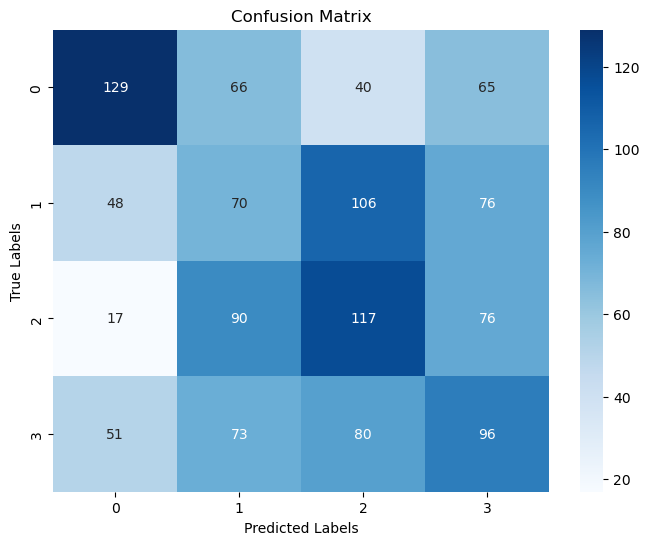

In [92]:
print("Confusion Matrix for all animals:")
print(conf_matrix)
# Create a heatmap for visualization
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Draft

In [58]:
exps=data.exp.unique()
weightall_sorted=[]
weightall=np.empty((4,0))
for exp in exps:

    _data=data[data['exp']==exp]
    _data=_data.dropna(axis=1)
    
    weight_sorted= contributionofneurons_allneuron(_data)[0]
    weight=np.array(contributionofneurons_allneuron(_data)[1])
    weightall_sorted=weightall_sorted+weight_sorted+[exp]
    
    weightall=np.hstack((weightall,weight))
#weightall_sorted=pd.DataFrame(weightall)

#weightall.to_csv("weightall.csv", index=False)



ValueError: operands could not be broadcast together with shapes (0,) (21,45) 

In [148]:
weightall



array([[1.63582763e-02, 9.81950546e-03, 5.83960442e-03, 2.06721241e-04,
        3.51013526e-03, 1.48617935e-02, 1.98808501e-03, 1.12576582e-02,
        4.19711014e-03, 4.90601976e-04, 2.32730698e-02, 1.29656155e-02,
        7.04205735e-04, 1.18802142e-02, 8.61858703e-03, 3.07900359e-03,
        7.22851065e-04, 1.92237464e-03, 3.02747354e-02, 3.05169992e-03,
        4.27747881e-03, 1.69625877e-03, 1.11861121e-03, 1.31793635e-02,
        1.13512772e-02, 1.11106199e-03, 2.56733396e-04, 3.99784882e-02,
        7.84352634e-03, 2.06080163e-03, 9.54058868e-03, 2.96222867e-03,
        2.43769082e-03, 7.38415728e-03, 1.68259731e-02, 1.87983470e-03,
        1.58520366e-02, 9.37743340e-03, 4.12533114e-03, 3.87326735e-03,
        1.21207173e-02, 1.01862256e-02, 6.67143958e-03, 1.77006234e-02,
        8.78624174e-03, 6.15722651e-04, 2.00404631e-04, 1.75444683e-02,
        9.27486959e-03, 1.58463203e-02, 5.38983941e-03, 1.73923155e-03,
        4.42517725e-02, 1.17486717e-02, 1.37714371e-03, 3.722835

In [9]:
weight23=np.empty((78,2))
weight23[:,0]=weightall[0]
weight23[:,1]=weightall[1]


ValueError: could not broadcast input array from shape (50,) into shape (78,)

/opt/conda/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1], dtype=int32)

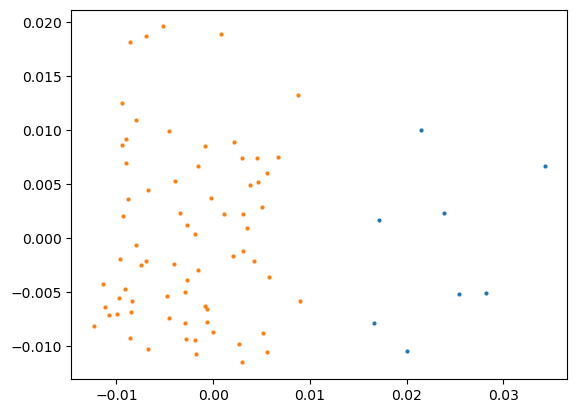

In [675]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
pca=PCA(n_components=2)
principal_components=pca.fit_transform(weight23)
kmeans=KMeans(n_clusters=2)
cluster_labels=kmeans.fit_predict(weight23)
labels=np.unique(cluster_labels)
for i in labels:
    plt.scatter(principal_components[cluster_labels==i,0],principal_components[cluster_labels==i,1],label=i,s=4)
cluster_labels

[47 15 51 17  5 50 66 41 42  0 76 71  9  7 59  1 22 32 38 11 18 75  3 12
 10 24 72 70 74 62 63 49 20 45 73 26 57 39 34 43  6 77 16 54 52 64 68 65
  8 37 48 28 56 40 21 55 33 46 60 23 53 35  2  4 36 27 13 19 29 14 25 31
 69 44 58 30 61 67]


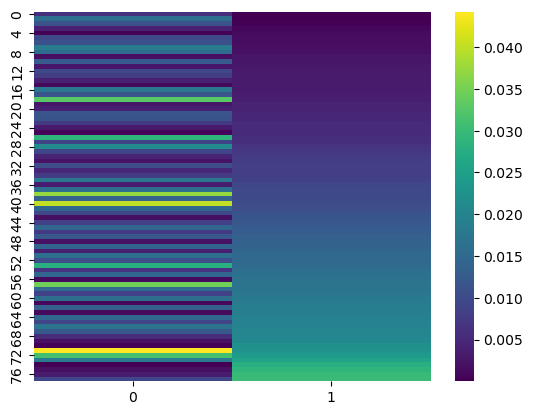

In [682]:

indices=np.argsort(weight23[:,1])
weight23_sorted=weight23[indices]
sns.heatmap(weight23_sorted, cmap='viridis')
print(indices)



In [37]:
datata=model.named_steps['logisticregression'].coef_

chunk_size = 45

# Calculate the averages for every 45 columns within the same row
averages = [row[i:i+chunk_size].mean() for row in datata for i in range(0, len(row), chunk_size)]
np.array(averages).shape
averages=abs(np.array(averages).reshape(datata.shape[0],int(datata.shape[1]/chunk_size)) )
averages_odor2sorted=averages[:, averages[0, :].argsort()]
indices=averages[0, :].argsort()
sns.heatmap(averages_odor2sorted, cmap='viridis')
indices

NameError: name 'model' is not defined

In [528]:
_data = data.query('exp=="033023_A66Nt_tracesfeature_odorbfcondition_3SECAFODORONSET"')
X = _data.filter(like='feature').to_numpy()
y = _data.odor.to_numpy()
model = make_pipeline(StandardScaler(), LogisticRegression())  # classification pipeline combines a standardization step (substract by mean and divide by std) and a vanilla logistic regression model
model = model.fit(X, y)
plt.figure(figsize=[20,10])
sns.heatmap(model.named_steps['logisticregression'].coef_, cmap='bwr')

/opt/conda/lib/python3.8/site-packages/sklearn/utils/extmath.py:1047: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.8/site-packages/sklearn/utils/extmath.py:1052: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/opt/conda/lib/python3.8/site-packages/sklearn/utils/extmath.py:1072: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

<Axes: >

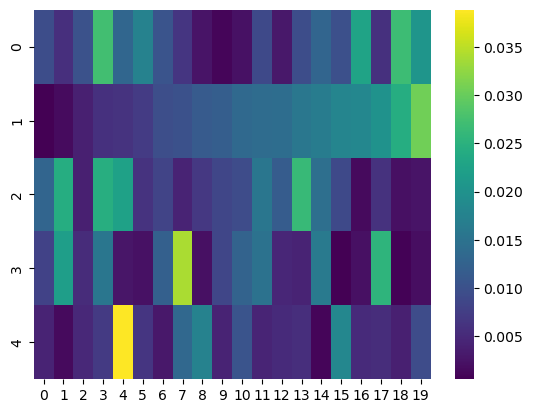

In [27]:
datata=model.named_steps['logisticregression'].coef_
chunk_size = 45

# Calculate the averages for every 45 columns within the same row
averages = [row[i:i+chunk_size].mean() for row in datata for i in range(0, len(row), chunk_size)]

averages=abs(np.array(averages).reshape(5,20))
averages_odor2sorted=averages[:, averages[1, :].argsort()]
sns.heatmap(averages_odor2sorted, cmap='viridis')

## Model training

## Model training, cross condition testing

In [42]:
# train data by experiment
_f1score_df, _accuracy_df = logistic_regression_performance_cross(
    data_train = data.query("exp==exp[0]"),
    # data_test = data.query("exp=='033023_A66Nt_tracesfeature_odorbfcondition_3SECAFODORONSET'"),
    data_test = data.query("exp==exp[0]"),
    rng=rng,
)

NameError: name 'logistic_regression_performance_cross' is not defined

## Visualization - merge animal
The following visualization first computes cross-validated model prediction score by animal and visualizes mean model prediction score and SEM aross animal (n=number of animal).

**NOTE: the code currently assumes one file contains one animal**

In [72]:
num_odor = data.groupby('exp').odor.apply(lambda x : len(np.unique(x))).unique()
assert len(num_odor) == 1, "Experiments have different number of odors presented!"
num_odor = int(num_odor)
chance_f1 = 1 / num_odor  # assuming random guess and balanced experimental design
chance_accuracy = 1 / num_odor

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

(0.0, 1.0)

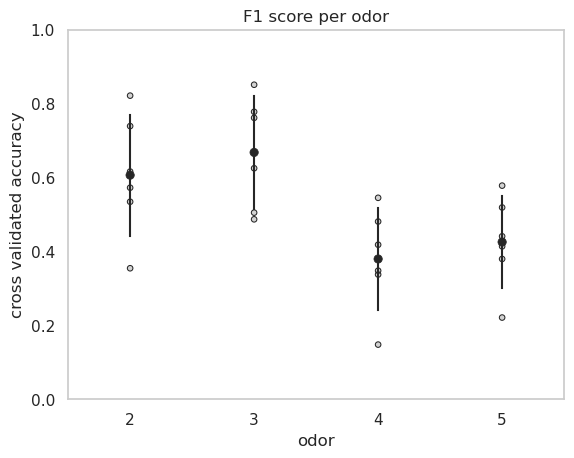

In [73]:
f1score_df_animal_mean = (
    f1score_df
    .groupby(['odor', 'exp'])
    .agg('mean')
    .reset_index()
)

fig = plt.figure()
(
    f1score_df_animal_mean
    .pipe(so.Plot, x='odor', y='f1_score')
    .add(so.Dots(color='k'), so.Dodge())
    .add(so.Dot(color='k'), so.Agg(), so.Dodge())
    .add(so.Range(color='k'), so.Est(errorbar="sd"), so.Dodge())
    .label(y='cross validated accuracy', x='odor', title='F1 score per odor')
    .theme({**axes_style("whitegrid"), "grid.linestyle": ""})
    .on(fig)
    .plot()
)
#plt.axhline(chance_f1, label='chance level', color='k', linestyle='--')
plt.ylim(0, 1)


In [74]:
f1score_df_animal_mean.to_csv('afcondition.csv')

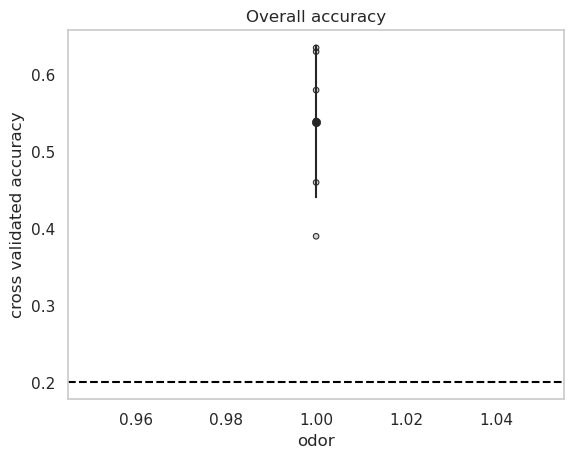

In [75]:
accuracy_df_animal_mean = (
    accuracy_df
    .groupby('exp')
    .agg('mean')
    .reset_index()
)
accuracy_df_animal_mean['x'] = 1  # place holder for plotting

fig = plt.figure()
(
    accuracy_df_animal_mean
    .pipe(so.Plot, x='x', y='accuracy')
    .add(so.Dots(color='k'), so.Dodge())
    .add(so.Dot(color='k'), so.Agg(), so.Dodge())
    .add(so.Range(color='k'), so.Est(errorbar="sd"), so.Dodge())
    .label(y='cross validated accuracy', x='odor', title='Overall accuracy')
    .theme({**axes_style("whitegrid"), "grid.linestyle": ""})
    .on(fig)
    .plot()
)
plt.axhline(chance_accuracy, label='chance level', color='k', linestyle='--')


## Stats across animals
**NOTE: These data points are i.i.d samples. These results are more trustworthy than the following per animal tests.**

### Whether overall accuracy is significant?

In [76]:
stats.ttest_1samp(accuracy_df_animal_mean.accuracy, chance_accuracy)  # test whether model could predict odors better than chance

TtestResult(statistic=8.512856155427677, pvalue=0.00036793438044193185, df=5)

### Whether per class f1 score is significant? 

In [77]:
pvalues = []
for odor, trials in f1score_df.groupby('odor'):
    t, p = stats.ttest_1samp(trials.f1_score, chance_f1)
    pvalues.append(dict(odor=odor, p=p))  # store p values for visualization later
pvalues = pd.DataFrame(pvalues)
pvalues['p'] = sms.multitest.fdrcorrection(pvalues['p'])[1]  # correct pvalues for multiple comparisons across odors
display(pvalues)

,odor,p
0,2,5.185523e-20
1,3,2.473355e-22
2,4,2.545590e-09
3,5,1.926207e-11


### Whether there are differences in performance across odor?

In [78]:
# 1-way anova
print(sm.stats.anova_lm(smf.ols(data=f1score_df_animal_mean, formula='f1_score ~ C(odor)').fit()))
# pair-wise comparison
pvalues = []
for odor1, odor2 in combinations(f1score_df_animal_mean.odor.unique(), 2):
    t, p = stats.ttest_ind(f1score_df_animal_mean.loc[f1score_df_animal_mean.odor==odor1, 'f1_score'], f1score_df_animal_mean.loc[f1score_df_animal_mean.odor==odor2, 'f1_score'])
    if t > 0:
        pvalues.append({'test':f'{odor1} > {odor2}', 'p':p})
    else:
        pvalues.append({'test':f'{odor1} < {odor2}', 'p':p})
pvalues = pd.DataFrame(pvalues)
pvalues['sig'] = sms.multitest.fdrcorrection(pvalues.p)[0]
pvalues.p = sms.multitest.fdrcorrection(pvalues.p)[1]
print(pvalues)

            df    sum_sq   mean_sq         F    PR(>F)
C(odor)    3.0  0.347917  0.115972  5.507607  0.006352
Residual  20.0  0.421135  0.021057       NaN       NaN
    test         p    sig
0  2 < 3  0.558475  False
1  2 > 4  0.053585  False
2  2 > 5  0.083793  False
3  3 > 4  0.037863   True
4  3 > 5  0.037863   True
5  4 < 5  0.558475  False


## <font color='red'>NOTE: The following tests are based on cross-validated model performance scores. These scores are not i.i.d samples and tests based on them are known to have an inflated type I error. Avoid using them if possible.

## Visualization per animal

In [79]:
num_odor = data.groupby('exp').odor.apply(lambda x : len(np.unique(x))).unique()
assert len(num_odor) == 1, "Experiments have different number of odors presented!"
num_odor = int(num_odor)

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

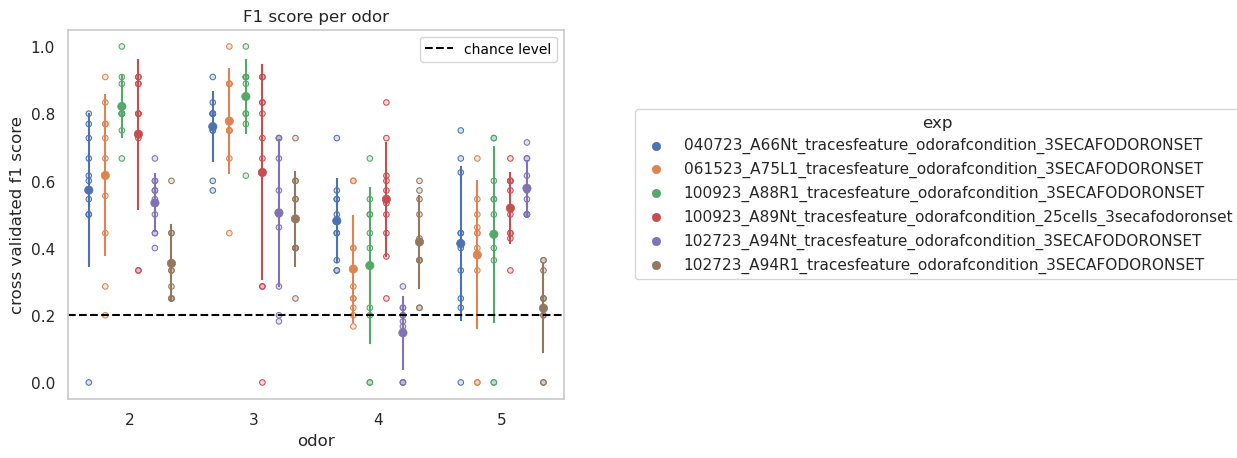

In [80]:
fig = plt.figure()
(
    f1score_df
    .pipe(so.Plot, x='odor', y='f1_score', color='exp')
    .add(so.Dots(), so.Dodge())
    .add(so.Dot(), so.Agg(), so.Dodge())
    .add(so.Range(), so.Est(errorbar="sd"), so.Dodge())
    .label(y='cross validated f1 score', title='F1 score per odor')
    .theme({**axes_style("whitegrid"), "grid.linestyle": ""})
    .on(fig)
    .plot()
)

chance_f1 = 1 / num_odor  # assuming random guess and balanced experimental desing
plt.axhline(chance_f1, label='chance level', color='k', linestyle='--')
plt.legend()




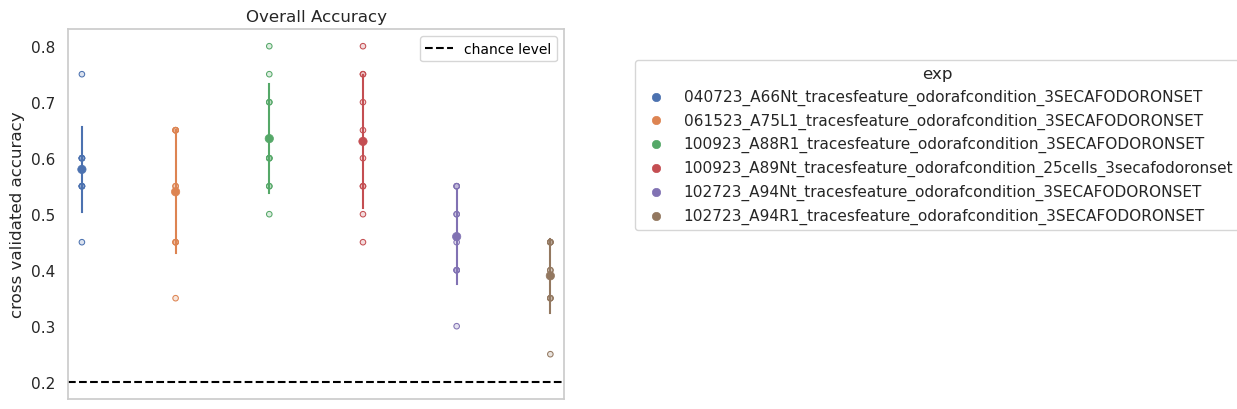

In [81]:
fig = plt.figure()
(
    accuracy_df
    .pipe(so.Plot, x='exp', y='accuracy', color='exp')
    .add(so.Dots(), so.Dodge())
    .add(so.Dot(), so.Agg(), so.Dodge())
    .add(so.Range(), so.Est(errorbar="sd"), so.Dodge())
    .label(y='cross validated accuracy', x='', title='Overall Accuracy')
    .theme({**axes_style("whitegrid"), "grid.linestyle": ""})
    .on(fig)
    .plot()
)
plt.xticks([], [])
chance_accuracy = 1 / num_odor
plt.axhline(chance_accuracy, label='chance level', color='k', linestyle='--')  #TODO: baseline = 1/num of odors, it is hard-coded to be 5 here, ideally this value should come from data
plt.legend()

In [82]:
from scipy import stats
from statsmodels import stats as sms
from statsmodels import api as sm
from statsmodels.formula import api as smf

### Whether overall accuracy is significant?

In [83]:
accuracy_df['p'] = np.nan
for exp, trials in accuracy_df.groupby('exp'):
    t, p = stats.ttest_1samp(trials.accuracy, chance_accuracy)
    accuracy_df.loc[accuracy_df.exp==exp, 'p'] = p  # store p values for visualization later

accuracy_df[['exp', 'p']].drop_duplicates()

,exp,p
0,040723_A66Nt_tracesfeature_odorafcondition_3SE...,6.563138e-08
0,061523_A75L1_tracesfeature_odorafcondition_3SE...,4.342084e-06
0,100923_A88R1_tracesfeature_odorafcondition_3SE...,1.888796e-07
0,100923_A89Nt_tracesfeature_odorafcondition_25c...,1.111867e-06
0,102723_A94Nt_tracesfeature_odorafcondition_3SE...,4.415857e-06
0,102723_A94R1_tracesfeature_odorafcondition_3SE...,7.610164e-06


### Whether per class f1 score is significant? 

In [84]:
pvalues = []
for exp, odors in f1score_df.groupby('exp'):
    for odor, trials in odors.groupby('odor'):
        t, p = stats.ttest_1samp(trials.f1_score, chance_f1)
        pvalues.append(dict(exp=exp, odor=odor, p=p))  # store p values for visualization later
pvalues = pd.DataFrame(pvalues)
pvalues['p'] = pvalues.groupby('exp')['p'].transform(lambda p : sms.multitest.fdrcorrection(p.to_numpy())[1])  # correct pvalues for multiple comparisons across odors
f1score_df = f1score_df.merge(pvalues)

f1score_df[['exp', 'odor', 'p']].drop_duplicates()

,exp,odor,p
0,040723_A66Nt_tracesfeature_odorafcondition_3SE...,2,7.708224e-04
10,040723_A66Nt_tracesfeature_odorafcondition_3SE...,3,1.334701e-07
20,040723_A66Nt_tracesfeature_odorafcondition_3SE...,4,1.033694e-04
30,040723_A66Nt_tracesfeature_odorafcondition_3SE...,5,1.564731e-02
40,061523_A75L1_tracesfeature_odorafcondition_3SE...,2,7.357524e-04
50,061523_A75L1_tracesfeature_odorafcondition_3SE...,3,3.360780e-06
60,061523_A75L1_tracesfeature_odorafcondition_3SE...,4,2.886593e-02
70,061523_A75L1_tracesfeature_odorafcondition_3SE...,5,2.886593e-02
80,100923_A88R1_tracesfeature_odorafcondition_3SE...,2,1.948738e-08
90,100923_A88R1_tracesfeature_odorafcondition_3SE...,3,2.723232e-08


### Whether there are differences in performance across odor?

In [85]:
for exp, odors in f1score_df.groupby('exp'):
    # 1-way anova
    print(exp)
    print(sm.stats.anova_lm(smf.ols(data=odors, formula='f1_score ~ C(odor)').fit()))
    # pair-wise comparison
    pvalues = []
    for odor1, odor2 in combinations(odors.odor.unique(), 2):
        t, p = stats.ttest_ind(odors.loc[odors.odor==odor1, 'f1_score'], odors.loc[odors.odor==odor2, 'f1_score'])
        if t > 0:
            pvalues.append({'test':f'{odor1} > {odor2}', 'p':p})
        else:
            pvalues.append({'test':f'{odor1} < {odor2}', 'p':p})
    pvalues = pd.DataFrame(pvalues)
    pvalues['sig'] = sms.multitest.fdrcorrection(pvalues.p)[0]
    pvalues.p = sms.multitest.fdrcorrection(pvalues.p)[1]
    print(pvalues)

040723_A66Nt_tracesfeature_odorafcondition_3SECAFODORONSET
            df    sum_sq   mean_sq         F    PR(>F)
C(odor)    3.0  0.683651  0.227884  7.056066  0.000752
Residual  36.0  1.162661  0.032296       NaN       NaN
    test         p    sig
0  2 < 3  0.055381  False
1  2 > 4  0.333606  False
2  2 > 5  0.203448  False
3  3 > 4  0.000186   True
4  3 > 5  0.001018   True
5  4 > 5  0.421718  False
061523_A75L1_tracesfeature_odorafcondition_3SECAFODORONSET
            df    sum_sq   mean_sq          F    PR(>F)
C(odor)    3.0  1.284736  0.428245  11.183618  0.000025
Residual  36.0  1.378519  0.038292        NaN       NaN
    test         p    sig
0  2 < 3  0.105577  False
1  2 > 4  0.012848   True
2  2 > 5  0.049120   True
3  3 > 4  0.000036   True
4  3 > 5  0.000524   True
5  4 < 5  0.627478  False
100923_A88R1_tracesfeature_odorafcondition_3SECAFODORONSET
            df    sum_sq   mean_sq          F        PR(>F)
C(odor)    3.0  1.999784  0.666595  18.898456  1.569310e-07
Residu